> **Disclaimer**: This notebook is based on the blog post  
> [*Efficient Model Adaptation with LoRA: From MNIST to Fashion-MNIST*](https://medium.com/@chiragbajaj25/efficient-model-adaptation-with-lora-from-mnist-to-fashion-mnist-46e4cd31519b)  
> by Chirag Bajaj. While I have adapted and modified parts of the original content, the core ideas and structure are derived from the original post. Full credit goes to the original author for the work.


# Low Rank Adaptation (LoRA) 

In recent years, parameter-efficient fine-tuning techniques have emerged as powerful tools for adapting large pretrained models to new tasks with minimal computational overhead. Among these methods, **LoRA (Low-Rank Adaptation)** offers a particularly elegant and effective solution by injecting low-rank trainable matrices into existing layers of a frozen model. Instead of updating all weights, LoRA allows us to fine-tune only a small number of parameters—significantly reducing both memory usage and training time, without sacrificing much in terms of performance.




<div style="text-align: center;">
<img src="images/lora_update.png" width=800/>
</div>

Let's start by importing the necessary libraries and setting up the device. We will use PyTorch for our implementation, along with torchvision for data loading and transformations.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt  # For visualizations
import numpy as np
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Today's exercise
In this notebook, we explore how LoRA can be applied to a simple transfer learning scenario: adapting a model trained on MNIST (handwritten digits) to Fashion-MNIST (clothing images). Along the way, we will:

- Introduce the key idea behind LoRA and how it modifies standard linear layers
- Fine-tune a base model on MNIST and use LoRA to adapt it to Fashion-MNIST
- Compare performance and parameter counts between full fine-tuning and LoRA
- Highlight LoRA’s advantages in settings where efficiency is critical (e.g., edge devices, multi-task models)

<div style="text-align: center;">
<img src="images/lora_overview.jpg" />
</div>

Let's start by defining our dataloaders and transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)

fashion_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_trainloader = torch.utils.data.DataLoader(fashion_trainset, batch_size=64, shuffle=True)

fashion_testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.83MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 924kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.76MB/s]
100%|██████████| 26.4M/26.4M [00:18<00:00, 1.40MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 218kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.50MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.9MB/s]


# Visualize MNIST Samples

To better understand the dataset, let's visualize some samples from the MNIST dataset. This will help us get a sense of the data we are working with and the kind of images we will be training our model on.

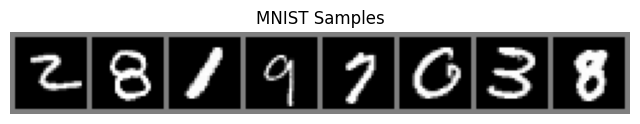

Labels: 2 8 1 9 7 0 3 8


In [5]:
dataiter = iter(mnist_trainloader)
images, labels = next(dataiter)

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

classes_mnist = [str(i) for i in range(10)]
imshow(torchvision.utils.make_grid(images[:8]), title='MNIST Samples')
print('Labels:', ' '.join(f'{classes_mnist[labels[j]]}' for j in range(8)))

Let's do the same for Fashion-MNIST. We will visualize a few samples from both datasets to see the differences and similarities between them.

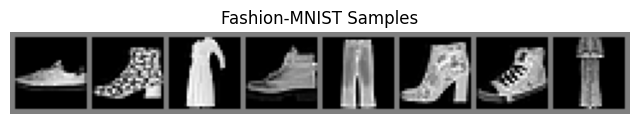

Labels: Sneaker Ankle Boot Dress Ankle Boot Trouser Ankle Boot Sneaker Dress


In [8]:
dataiter = iter(fashion_trainloader)
images, labels = next(dataiter)

classes_fashion = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
imshow(torchvision.utils.make_grid(images[:8]), title='Fashion-MNIST Samples')
print('Labels:', ' '.join(f'{classes_fashion[labels[j]]}' for j in range(8)))

# Define the Neural Network

We will define a simple feedforward neural network with two hidden layers. The architecture is as follows:

In [20]:
class SimpleANN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
print(f"Number of parameters being trained in the model: {sum(p.numel() for p in SimpleANN().parameters())}")

Number of parameters being trained in the model: 101770


# Train the Model

First, we will train the model on the MNIST dataset. We will use the SGD optimizer and a cross-entropy loss function. The training process will involve multiple epochs, during which we will update the model's weights based on the loss calculated from the predictions and the true labels.

Epoch 1/5, Loss: 0.7586
Epoch 2/5, Loss: 0.3668
Epoch 3/5, Loss: 0.3217
Epoch 4/5, Loss: 0.2949
Epoch 5/5, Loss: 0.2737


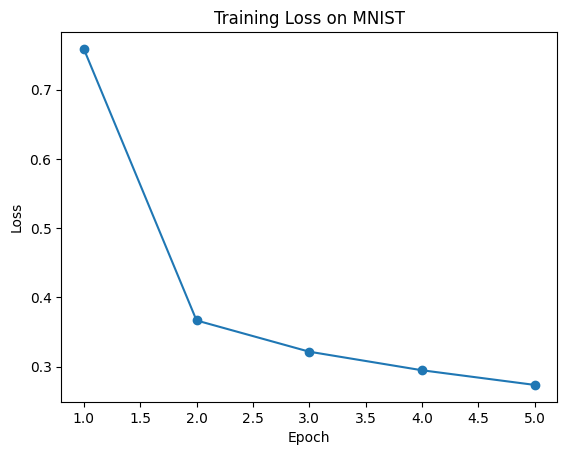

In [10]:
model = SimpleANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5
mnist_train_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in mnist_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(mnist_trainloader)
    mnist_train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

plt.plot(range(1, epochs+1), mnist_train_losses, marker='o')
plt.title('Training Loss on MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the Model

After training the model on the MNIST dataset, we will evaluate its performance on the test set. This will give us an idea of how well the model has learned to classify handwritten digits.

In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in mnist_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
mnist_accuracy = 100 * correct / total
print(f"Accuracy on MNIST test images: {mnist_accuracy:.2f}%")

torch.save(model.state_dict(), 'mnist_model.pth')

Accuracy on MNIST test images: 92.72%


# Implement LoRA

We will now implement the LoRA technique by modifying the linear layers of our neural network. The key idea is to inject low-rank trainable matrices into the existing layers, allowing us to fine-tune only a small number of parameters while keeping the rest of the model frozen.

In [13]:
model = SimpleANN().to(device)
model.load_state_dict(torch.load('mnist_model.pth'))

class LoRAFc(nn.Module):
    def __init__(self, layer, rank, device):
        super(LoRAFc, self).__init__()
        self.layer = layer
        self.rank = rank
        self.lora_A = nn.Parameter(torch.randn(self.layer.out_features, rank, device=device) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(rank, self.layer.in_features, device=device) * 0.01)
        self.layer.to(device)
        for param in self.layer.parameters():
            param.requires_grad = False  # Freeze original weights

    def forward(self, x):
        original_output = self.layer(x)
        lora_output = torch.matmul(x, self.lora_B.t())
        lora_output = torch.matmul(lora_output, self.lora_A.t())
        return original_output + lora_output

def apply_lora(model, rank, device):
    model.fc1 = LoRAFc(model.fc1, rank, device)

rank = 10
apply_lora(model, rank, device)

trainable_params_lora = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters being trained in LoRA fine-tuning: {trainable_params_lora}")

Number of parameters being trained in LoRA fine-tuning: 10410


# Fine-tune LoRA Model

Next, we will fine-tune the LoRA model on the Fashion-MNIST dataset. This process will involve updating the low-rank matrices while keeping the rest of the model's weights frozen. We will use the same training procedure as before, but this time we will focus on adapting the model to classify clothing images instead of handwritten digits.

LoRA Epoch 1/5, Loss: 1.3224
LoRA Epoch 2/5, Loss: 0.6748
LoRA Epoch 3/5, Loss: 0.5921
LoRA Epoch 4/5, Loss: 0.5427
LoRA Epoch 5/5, Loss: 0.5083


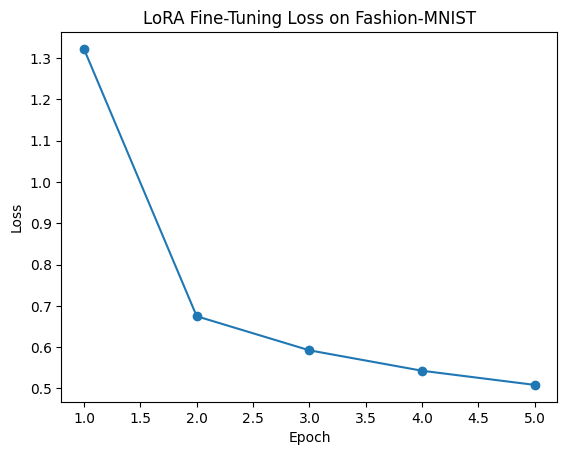

In [14]:
optimizer_lora = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
epochs_lora = 5
lora_losses = []
for epoch in range(epochs_lora):
    running_loss = 0.0
    for images, labels in fashion_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_lora.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lora.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(fashion_trainloader)
    lora_losses.append(avg_loss)
    print(f"LoRA Epoch {epoch+1}/{epochs_lora}, Loss: {avg_loss:.4f}")

plt.plot(range(1, epochs_lora+1), lora_losses, marker='o')
plt.title('LoRA Fine-Tuning Loss on Fashion-MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate LoRA

After fine-tuning the LoRA model on the Fashion-MNIST dataset, we will evaluate its performance on the test set. This will help us understand how well the model has adapted to the new task and whether it can generalize to unseen data.

In [15]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in fashion_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fashion_accuracy = 100 * correct / total
print(f"LoRA fine-tuned model accuracy on Fashion-MNIST test images: {fashion_accuracy:.2f}%")

LoRA fine-tuned model accuracy on Fashion-MNIST test images: 81.32%


# Full Fine-Tuning for Comparison

Finally, we will perform full fine-tuning on the same Fashion-MNIST dataset. This will involve updating all the model's weights, allowing us to compare the performance and parameter counts between full fine-tuning and LoRA.

Number of parameters being trained in full fine-tuning: 101770
Full FT Epoch 1/5, Loss: 0.7713
Full FT Epoch 2/5, Loss: 0.5087
Full FT Epoch 3/5, Loss: 0.4597
Full FT Epoch 4/5, Loss: 0.4318
Full FT Epoch 5/5, Loss: 0.4122


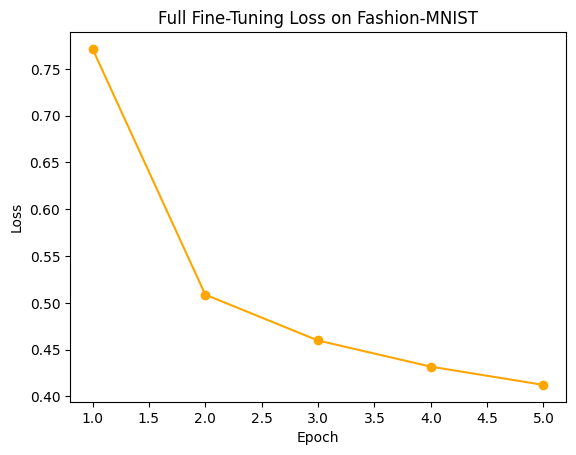

In [16]:
model_full_ft = SimpleANN().to(device)
model_full_ft.load_state_dict(torch.load('mnist_model.pth'))

optimizer_full_ft = optim.SGD(model_full_ft.parameters(), lr=0.01)

trainable_params_full = sum(p.numel() for p in model_full_ft.parameters() if p.requires_grad)
print(f"Number of parameters being trained in full fine-tuning: {trainable_params_full}")


epochs_full_ft = 5
full_ft_losses = []
for epoch in range(epochs_full_ft):
    running_loss = 0.0
    for images, labels in fashion_trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer_full_ft.zero_grad()
        outputs = model_full_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_full_ft.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(fashion_trainloader)
    full_ft_losses.append(avg_loss)
    print(f"Full FT Epoch {epoch+1}/{epochs_full_ft}, Loss: {avg_loss:.4f}")

plt.plot(range(1, epochs_full_ft+1), full_ft_losses, marker='o', color='orange')
plt.title('Full Fine-Tuning Loss on Fashion-MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the Fully Fine-Tuned Model

After fine-tuning the model on the Fashion-MNIST dataset, we will evaluate its performance on the test set. This will help us understand how well the fully fine-tuned model has learned to classify clothing images and how it compares to the LoRA model.

In [17]:
model_full_ft.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in fashion_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_full_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
fashion_accuracy_full_ft = 100 * correct / total
print(f"Fully fine-tuned model accuracy on Fashion-MNIST test images: {fashion_accuracy_full_ft:.2f}%")

Fully fine-tuned model accuracy on Fashion-MNIST test images: 84.03%


# Comparison

We will compare the performance of the LoRA model and the fully fine-tuned model on the Fashion-MNIST test set. This will involve analyzing metrics such as accuracy, loss, and parameter counts to understand the trade-offs between the two approaches.

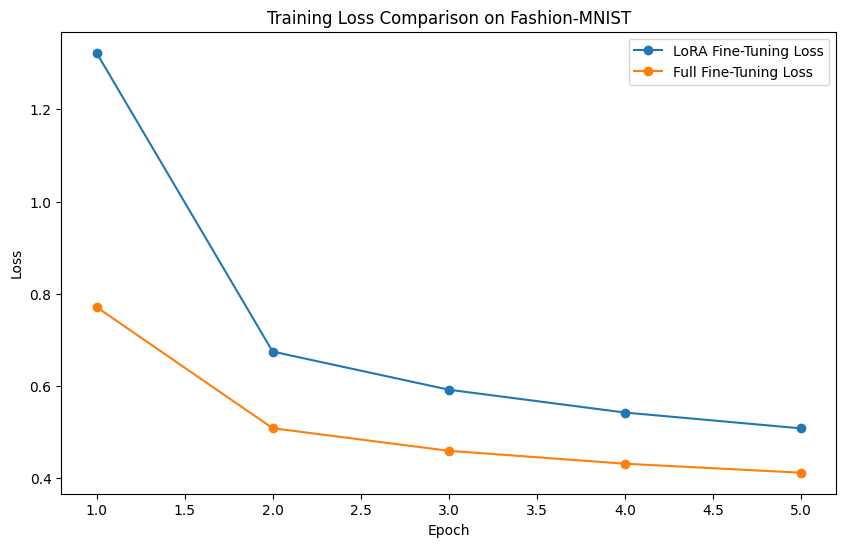

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs_lora+1), lora_losses, marker='o', label='LoRA Fine-Tuning Loss')
plt.plot(range(1, epochs_full_ft+1), full_ft_losses, marker='o', label='Full Fine-Tuning Loss')
plt.title('Training Loss Comparison on Fashion-MNIST')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

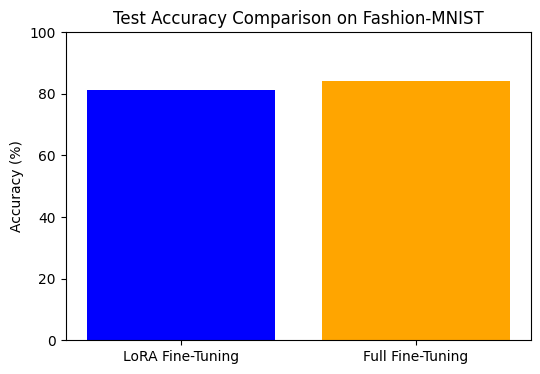

In [19]:
lora_accuracy = fashion_accuracy
full_ft_accuracy = fashion_accuracy_full_ft

plt.figure(figsize=(6,4))
methods = ['LoRA Fine-Tuning', 'Full Fine-Tuning']
accuracies = [lora_accuracy, full_ft_accuracy]
plt.bar(methods, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison on Fashion-MNIST')
plt.ylim(0, 100)
plt.show()

LoRA is particularly well-suited for scenarios where computational resources are limited, model deployment needs to be efficient, or rapid adaptation to multiple tasks is necessary. By fine-tuning only a small number of parameters in a low-rank subspace, LoRA dramatically reduces memory and storage requirements while preserving model performance. This makes it ideal for:

- Fine-tuning large models on small datasets
- Adapting a single pretrained model to multiple domains without catastrophic forgetting
- Deployment on edge devices or in production environments with tight latency and memory constraints
- Research workflows where quick iteration across tasks or conditions is essential

In essence, LoRA offers a principled way to scale fine-tuning efficiently—making large models more accessible, adaptable, and sustainable across diverse applications.
